In [1]:
from qick import *
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from tqdm import tqdm

In [2]:
import xrfclk
#xrfclk.set_ref_clks(lmk_freq=245.76, lmx_freq=491.52)

In [3]:
from pynq.pl_server.global_state import clear_global_state
clear_global_state()

In [4]:
soc = QickSoc(bitfile='/home/xilinx/jupyter_notebooks/qick/qick_demos/custom/drivers/base_MTS_15.bit')
soc_cfg = soc
print(soc_cfg)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.267
	Firmware timestamp: Tue Nov 19 17:20:20 2024

	Global clocks (MHz): tProcessor 350.000, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=3

In [16]:
### INITIALIZE SPI DEVICES ###
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/qick/qick_demos/custom/drivers')
from TIDAC80508 import TIDAC80508
tidac = TIDAC80508()
# from HMC7044 import HMC7044
# hmc = HMC7044()

### SET POWER FOR DACs ###
dac_2280 = soc_cfg.usp_rf_data_converter_0.dac_tiles[0].blocks[0]
dac_2280.SetDACVOP(30000)
dac_2281 = soc_cfg.usp_rf_data_converter_0.dac_tiles[0].blocks[1]
dac_2281.SetDACVOP(30000)
dac_2282 = soc_cfg.usp_rf_data_converter_0.dac_tiles[0].blocks[2]
dac_2282.SetDACVOP(30000)
dac_2283 = soc_cfg.usp_rf_data_converter_0.dac_tiles[0].blocks[3]
dac_2283.SetDACVOP(30000)
dac_2292 = soc_cfg.usp_rf_data_converter_0.dac_tiles[1].blocks[2]
dac_2292.SetDACVOP(5000)
dac_2230 = soc_cfg.usp_rf_data_converter_0.dac_tiles[2].blocks[0]
dac_2230.SetDACVOP(30000)
dac_2232 = soc_cfg.usp_rf_data_converter_0.dac_tiles[2].blocks[2]
dac_2232.SetDACVOP(30000)

### ENABLE MULTI TILE SYNCHRONIZATION ###
soc_cfg.usp_rf_data_converter_0.mts_dac_config.RefTile = 2
soc_cfg.usp_rf_data_converter_0.mts_dac_config.Tiles = 0b0001
soc_cfg.usp_rf_data_converter_0.mts_dac_config.SysRef_Enable = 1
soc_cfg.usp_rf_data_converter_0.mts_dac_config.Target_Latency = -1
soc_cfg.usp_rf_data_converter_0.mts_dac()

def reset_bias():
    tidac.set_bias(channel_cfg["DAC_bias"][0], bias_value=0)
    tidac.set_bias(channel_cfg["DAC_bias"][1], bias_value=0)
    tidac.set_bias(channel_cfg["DAC_bias"][2], bias_value=0)
    tidac.set_bias(channel_cfg["DAC_bias"][3], bias_value=0)
def set_sweetspots():
    tidac.set_bias(channel_cfg["DAC_bias"][0], bias_value=flux_cfg["q2_sweetspot"])
    tidac.set_bias(channel_cfg["DAC_bias"][1], bias_value=flux_cfg["q4_sweetspot"])
    tidac.set_bias(channel_cfg["DAC_bias"][2], bias_value=flux_cfg["q1_sweetspot"])
    tidac.set_bias(channel_cfg["DAC_bias"][3], bias_value=flux_cfg["q3_sweetspot"])

In [17]:
### DEFINE INPUTS AND OUTPUTS ###

DC_FLUX     = [5,2,6,7]
RF_FLUX     = [None,0,None,1]
DRIVE       = [2,3,4,5]
PROBE_CH    = 6
FEEDBACK_CH = [0,1,2,3] #ADC
MAX_GAIN    = 32766  
TOF         = 350

In [18]:
class ResonatorFluxDependanceProgram(AveragerProgram):
    
    def ns2cycles(self, ns, gen_ch=None, ro_ch=None):
        return self.us2cycles(ns/1000, gen_ch=gen_ch, ro_ch=ro_ch)

    def initialize(self):
        cfg=self.cfg
        
        probe_ch    = cfg["probe_ch"]        
        feedback_ch = cfg["feedback_ch"]        
        ro_pulse_shape  = cfg["ro_pulse_shape"]
        ro_pulse_length = self.ns2cycles(cfg["ro_pulse_length"], gen_ch=probe_ch)  
        self.declare_gen(ch=probe_ch, 
                         nqz=cfg["probe_ch_nqz"], 
                         mux_freqs=self.cfg['ro_pulse_frequency'], 
                         mux_gains=self.cfg['ro_pulse_gain'])
        self.set_pulse_registers(ch=probe_ch, 
                                 style=ro_pulse_shape, 
                                 length=ro_pulse_length, 
                                 mask=[0,1,2,3])        
        for iCh, ch in enumerate(feedback_ch):
            self.declare_readout(ch=ch, 
                                 freq=self.cfg['acquisition_frequency'][iCh], 
                                 length = self.ns2cycles(self.cfg['acquisition_length'], ro_ch=ch), 
                                 gen_ch=probe_ch)
        self.synci(500)  # give processor some time to configure pulses
    
    def body(self):
        cfg=self.cfg
        probe_ch    = cfg["probe_ch"]
        feedback_ch = cfg["feedback_ch"]
        ro_pulse_start       = self.ns2cycles(cfg["ro_pulse_start"])     
        self.measure(pulse_ch= probe_ch, 
                     adcs = feedback_ch, 
                     adc_trig_offset=self.ns2cycles(cfg["delay_before_acquisition"]), 
                     pins = [0], wait=True, 
                     syncdelay=self.ns2cycles(cfg["relaxation_time"]), 
                     t=ro_pulse_start)

In [25]:
channel_cfg = { "DAC_bias"      : DC_FLUX,
                "probe_ch"      : PROBE_CH,
                "probe_ch_nqz"  : 2,
                "feedback_ch"   : FEEDBACK_CH,
}

flux_cfg = {    "q1_sweetspot": 0, # update
                "q2_sweetspot": 0, # update
                "q3_sweetspot": 0, # update
                "q4_sweetspot": 0, # update
} 

readout_cfg={   "ro_pulse_start": 0,       # [ns]
                "ro_pulse_gain" : [0.25, 0.25, 0.25, 0.25],
                "ro_pulse_length": 3000,   # [ns]
                "ro_pulse_shape": "const", # rectangular
                "ro_pulse_frequency"    : [7430.829, 7510.710, 7547.810, 7583.269],
                "freq_original"         : [7430.829, 7510.710, 7547.810, 7583.269],
                "acquisition_frequency" : [7430.829, 7510.710, 7547.810, 7583.269],
                "acquisition_length": 3500,      # [ns]
                "delay_before_acquisition": TOF, # missing lags[ns]
                "reps": 100,                     # Fixed
                "soft_avgs": 1,                  # [ns],
                "relaxation_time": 10000}        # [ns]
"""
[7430.829, 7510.710, 7547.810, 7583.269],
"""

'\n[7430.829, 7510.710, 7547.810, 7583.269],\n'

In [26]:
def run_resonator_flux_dependence(gain_range):
    fig = go.Figure()
    experiment_points = 101
    results_matrix = np.zeros((len(gain_range), 4*experiment_points))
    for idx, gain in enumerate(tqdm(gain_range)):
        tidac.set_bias(channel_cfg["DAC_bias"][0], bias_value=gain) #+flux_cfg["q1_sweetspot"]
        tidac.set_bias(channel_cfg["DAC_bias"][1], bias_value=gain) #+flux_cfg["q2_sweetspot"]
        tidac.set_bias(channel_cfg["DAC_bias"][2], bias_value=gain) #+flux_cfg["q3_sweetspot"]
        tidac.set_bias(channel_cfg["DAC_bias"][3], bias_value=gain) #+flux_cfg["q4_sweetspot"]
        frequency_range = np.linspace(-2, 2, experiment_points)
        results=[]
        for frequency in frequency_range:
            readout_cfg["ro_pulse_frequency"][0]    = frequency + readout_cfg["freq_original"][0]
            readout_cfg["acquisition_frequency"][0] = frequency + readout_cfg["freq_original"][0]
            readout_cfg["ro_pulse_frequency"][1]    = frequency + readout_cfg["freq_original"][1]
            readout_cfg["acquisition_frequency"][1] = frequency + readout_cfg["freq_original"][1]
            readout_cfg["ro_pulse_frequency"][2]    = frequency + readout_cfg["freq_original"][2]
            readout_cfg["acquisition_frequency"][2] = frequency + readout_cfg["freq_original"][2]
            readout_cfg["ro_pulse_frequency"][3]    = frequency + readout_cfg["freq_original"][3]
            readout_cfg["acquisition_frequency"][3] = frequency + readout_cfg["freq_original"][3]            
            program_cfg = {**channel_cfg,**readout_cfg} 
            program = ResonatorFluxDependanceProgram(soccfg=soc_cfg, cfg=program_cfg)
            results.append(program.acquire(soc, start_src="internal"))
        results = np.transpose(results)
        results_matrix[idx, 0*experiment_points:1*experiment_points] = np.abs(results[0][0][0] + 1j*results[0][0][1])
        results_matrix[idx, 1*experiment_points:2*experiment_points] = np.abs(results[0][1][0] + 1j*results[0][1][1]) 
        results_matrix[idx, 2*experiment_points:3*experiment_points] = np.abs(results[0][2][0] + 1j*results[0][2][1]) 
        results_matrix[idx, 3*experiment_points:4*experiment_points] = np.abs(results[0][3][0] + 1j*results[0][3][1]) 
    reset_bias()
    cf = np.concatenate((frequency_range+readout_cfg["freq_original"][0], frequency_range+readout_cfg["freq_original"][1], frequency_range+readout_cfg["freq_original"][2], frequency_range+readout_cfg["freq_original"][3]))
    #print(cf)
    fig.add_trace(go.Heatmap(z=results_matrix, x=cf, y=gain_range, colorscale='Viridis', colorbar=dict(title='Signal Magnitude [a.u.]')))
    fig.update_layout(title='Resonator Spectroscopy Flux', height = 700, width = 1500)
    fig.show()

100%|██████████| 101/101 [02:14<00:00,  1.34s/it]


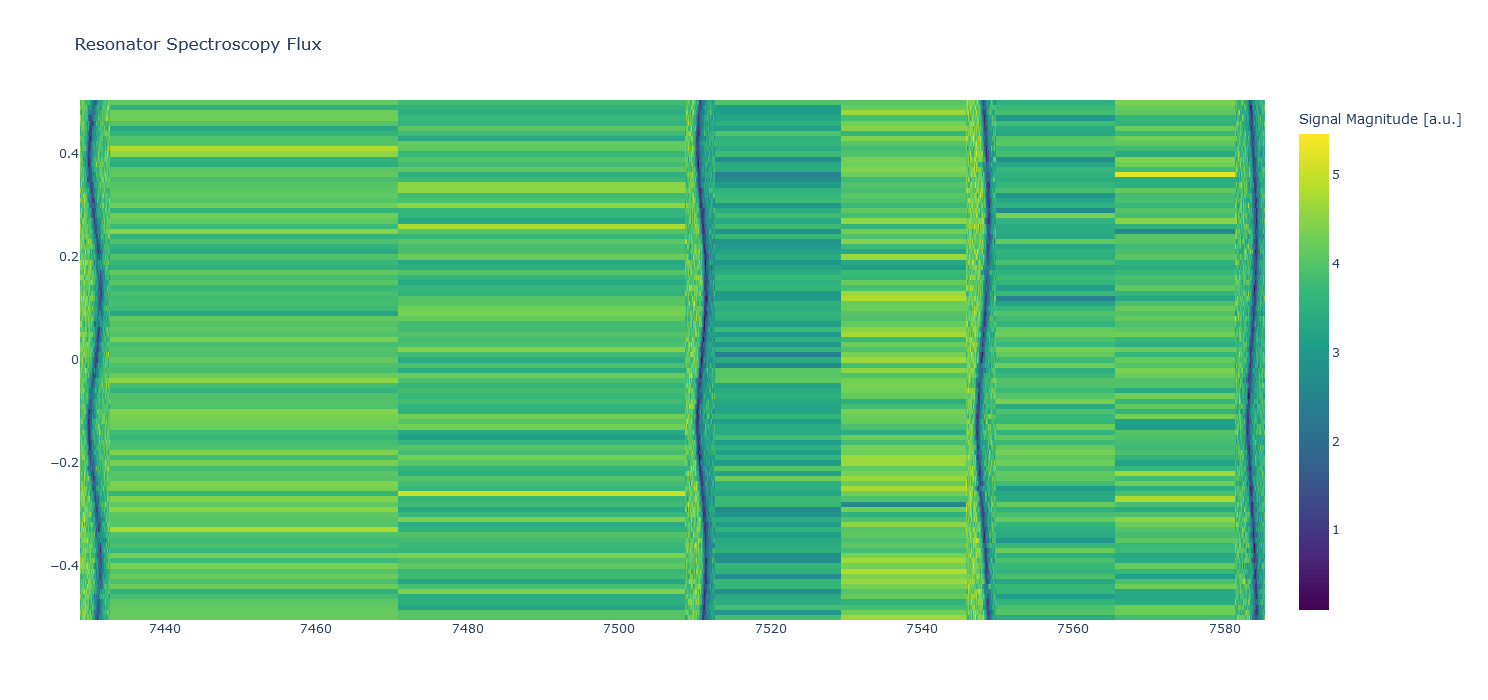

In [27]:
r = run_resonator_flux_dependence(gain_range=np.linspace(-.5, .5, 101))